# Module 4 - Exercise 2: Fine-Tuning Fundamentals

## Learning Objectives
- Understand the concept and benefits of fine-tuning pretrained models
- Learn how to adapt pretrained models to new tasks
- Master techniques for freezing and unfreezing layers
- Compare performance between training from scratch and fine-tuning
- Implement progressive unfreezing strategies

## Environment Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple
import time
from collections import defaultdict

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

Using device: cuda


## Section 1: Data Preparation

We will work with a subset of CIFAR-10, focusing on distinguishing between animals (cats, dogs, birds, horses) and vehicles (cars, trucks, ships, planes). This binary classification task will demonstrate how pretrained models can be adapted to new problems.

In [2]:
# Define data transformations
# Note: Pretrained models expect specific input normalization
transform_train = transforms.Compose([
    transforms.Resize(224),  # ResNet expects 224x224 images
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet statistics
                       std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

# Download CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                      download=True, transform=transform_test)

# CIFAR-10 classes: 0=plane, 1=car, 2=bird, 3=cat, 4=deer, 5=dog, 6=frog, 7=horse, 8=ship, 9=truck
# Animals: 2(bird), 3(cat), 4(deer), 5(dog), 6(frog), 7(horse) -> label 0
# Vehicles: 0(plane), 1(car), 8(ship), 9(truck) -> label 1

def create_binary_dataset(dataset, num_samples=2000):
    """Create a binary classification dataset: animals vs vehicles"""
    animals = [2, 3, 4, 5, 6, 7]
    vehicles = [0, 1, 8, 9]

    data = []
    labels = []

    samples_per_class = num_samples // 2
    animal_count = 0
    vehicle_count = 0

    for img, label in dataset:
        if label in animals and animal_count < samples_per_class:
            data.append(img)
            labels.append(0)  # Animals = 0
            animal_count += 1
        elif label in vehicles and vehicle_count < samples_per_class:
            data.append(img)
            labels.append(1)  # Vehicles = 1
            vehicle_count += 1

        if animal_count >= samples_per_class and vehicle_count >= samples_per_class:
            break

    return torch.stack(data), torch.tensor(labels)

# Create smaller datasets for faster training
print("Creating binary classification datasets...")
train_data, train_labels = create_binary_dataset(trainset, num_samples=2000)
test_data, test_labels = create_binary_dataset(testset, num_samples=400)

# Create DataLoaders
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Class distribution - Train: Animals={sum(train_labels==0)}, Vehicles={sum(train_labels==1)}")
print(f"Class distribution - Test: Animals={sum(test_labels==0)}, Vehicles={sum(test_labels==1)}")

100%|██████████| 170M/170M [00:03<00:00, 45.1MB/s]


Creating binary classification datasets...
Training samples: 2000
Test samples: 400
Class distribution - Train: Animals=1000, Vehicles=1000
Class distribution - Test: Animals=200, Vehicles=200


### Visualize Sample Data

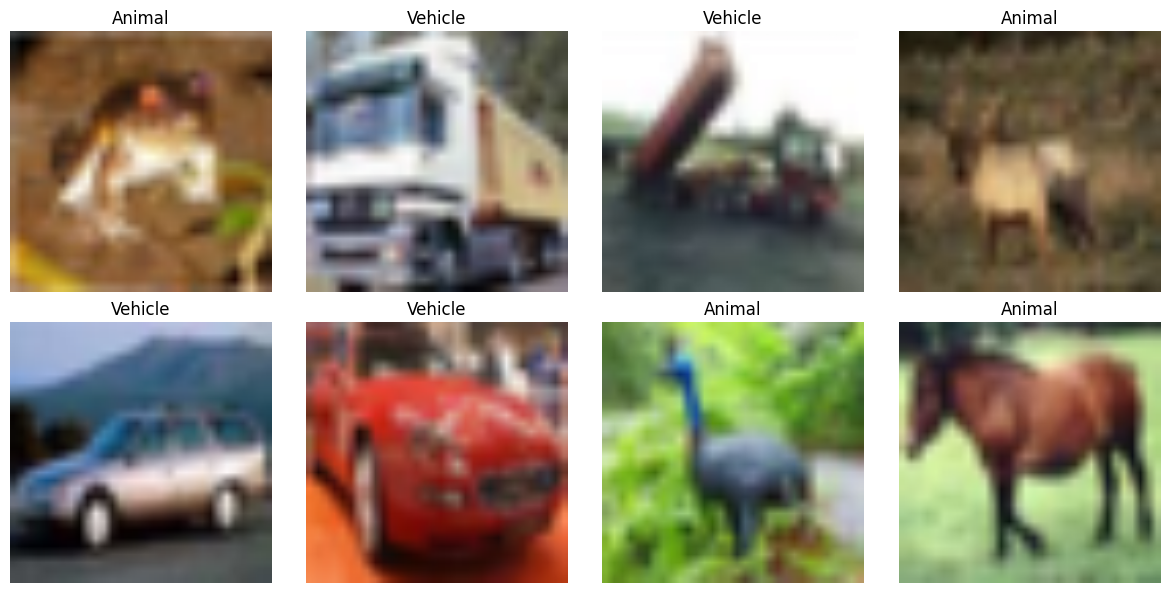

In [8]:
# TODO: Implement a function to denormalize and display images
def denormalize_image(img_tensor):
    """Denormalize image tensor for visualization"""
    # ImageNet normalization parameters
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    # TODO: Denormalize the image tensor
    # Hint: reversed_img = img * std + mean
    denormalized =img_tensor*std+mean

    return denormalized

# Visualize some samples
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
class_names = ['Animal', 'Vehicle']

for i in range(8):
    img, label = train_dataset[i]

    # Denormalize for display
    img_display = denormalize_image(img)
    if img_display is not None:
        img_display = np.clip(img_display.permute(1, 2, 0).numpy(), 0, 1)
    else:
        img_display = np.zeros((224, 224, 3))

    ax = axes[i // 4, i % 4]
    ax.imshow(img_display)
    ax.set_title(f"{class_names[label]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

## Section 2: Training a Custom Model from Scratch

First, let's establish a baseline by training a simple CNN from scratch. This will help us appreciate the benefits of fine-tuning.

In [11]:
class SimpleCNN(nn.Module):
    """A simple CNN for binary classification"""
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # TODO: Define the convolutional layers
        # Architecture: Conv(3->32) -> Conv(32->64) -> Conv(64->128)
        # Use kernel_size=3, padding=1 for all conv layers
        self.conv1 = nn.Conv3d(3,32,kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(32,64,kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv3d(64,128,kernel_size=3, stride=1, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Calculate the size after convolutions and pooling
        # Input: 224x224, after 3 pooling: 224/8 = 28
        # TODO: Define fully connected layers
        # fc1: (128 * 28 * 28) -> 256
        # fc2: 256 -> 64
        # fc3: 64 -> 2 (binary classification)
        self.fc1 = nn.Linear(128 * 28 * 28,256)
        self.fc2 = nn.Linear(256,64)
        self.fc3 = nn.Linear(64,2)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # TODO: Implement the forward pass
        # Apply conv -> relu -> pool for each conv layer
        # Then flatten and pass through FC layers with ReLU and dropout

        # Convolutional layers
        x = F.relu(self.conv1(x))  # First conv block
        x = F.relu(self.conv2(x))   # Second conv block
        x = F.relu(self.conv3(x))   # Third conv block

        # Flatten
        x = x.flatten()

        # Fully connected layers
        x = F.relu(self.fc1(x))   # fc1 with ReLU and dropout
        x = F.relu(self.fc2(x))    # fc2 with ReLU and dropout
        x = F.relu(self.fc3(x))    # fc3 (output)

        return x

# Test the model creation
model_scratch = SimpleCNN().to(device)
print(f"Model parameters: {sum(p.numel() for p in model_scratch.parameters()):,}")

Model parameters: 25,986,242


### Training Function

In [16]:
def train_model(model, train_loader, test_loader, num_epochs=10, lr=0.001, model_name="Model"):
    """Generic training function for any model"""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # TODO: Implement the training step
            # 1. Zero gradients
            # 2. Forward pass
            # 3. Calculate loss
            # 4. Backward pass
            # 5. Update weights

            optimizer.zero_grad()
            outputs = model(inputs)  # Forward pass
            loss = criterion(labels,outputs)  # Calculate loss


            if loss is not None:
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()

        # Evaluation phase
        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

        # Calculate metrics
        train_loss_avg = train_loss / len(train_loader)
        train_acc = 100 * train_correct / train_total if train_total > 0 else 0
        test_loss_avg = test_loss / len(test_loader)
        test_acc = 100 * test_correct / test_total

        history['train_loss'].append(train_loss_avg)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss_avg)
        history['test_acc'].append(test_acc)

        if (epoch + 1) % 2 == 0:
            print(f"{model_name} - Epoch [{epoch+1}/{num_epochs}]: "
                  f"Train Loss: {train_loss_avg:.4f}, Train Acc: {train_acc:.2f}%, "
                  f"Test Loss: {test_loss_avg:.4f}, Test Acc: {test_acc:.2f}%")

    return history

### Train the Custom Model

In [17]:
# TODO: Train the custom model from scratch
print("Training custom CNN from scratch...")
print("="*50)

# Initialize and train the model
model_scratch = SimpleCNN().to(device)
history_scratch = None  # TODO: Call train_model with appropriate parameters

if history_scratch:
    print(f"\nFinal Test Accuracy (from scratch): {history_scratch['test_acc'][-1]:.2f}%")

Training custom CNN from scratch...


## Section 3: Loading and Modifying a Pretrained Model

Now, let's use a pretrained ResNet18 model. Pretrained models are trained on large datasets (like ImageNet with 1.2M images and 1000 classes) and have learned rich feature representations that can be transferred to new tasks.

### Key Concepts:
- **Transfer Learning**: Using knowledge from one task to improve performance on another
- **Feature Extraction**: Lower layers learn general features (edges, textures) that are useful across tasks
- **Task-Specific Adaptation**: Only the final layers need to be modified for the new task

In [15]:
# Load pretrained ResNet18
print("Loading pretrained ResNet18...")
resnet18 = models.resnet18(pretrained=True)

# Examine the model architecture
print(f"\nOriginal ResNet18 architecture (last layers):")
print(f"Average Pooling: {resnet18.avgpool}")
print(f"Final FC Layer: {resnet18.fc}")
print(f"Output features: {resnet18.fc.out_features}")

# TODO: Modify the final layer for binary classification
# The original fc layer outputs 1000 classes (ImageNet)
# We need to replace it with a layer that outputs 2 classes

# Get the number of input features to the final layer
num_features = resnet18.fc.in_features
print(f"\nNumber of input features to final layer: {num_features}")

# TODO: Replace the final layer
# Create a new Linear layer: num_features -> 2
resnet18.fc = None

# Move model to device
model_pretrained = resnet18.to(device)

print(f"\nModified final layer: {model_pretrained.fc}")
print(f"Total parameters: {sum(p.numel() for p in model_pretrained.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model_pretrained.parameters() if p.requires_grad):,}")

Loading pretrained ResNet18...
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:01<00:00, 42.6MB/s]


Original ResNet18 architecture (last layers):
Average Pooling: AdaptiveAvgPool2d(output_size=(1, 1))
Final FC Layer: Linear(in_features=512, out_features=1000, bias=True)
Output features: 1000

Number of input features to final layer: 512

Modified final layer: None
Total parameters: 11,176,512
Trainable parameters: 11,176,512


## Section 4: Fine-Tuning with Frozen Layers

When fine-tuning, we typically start by freezing the pretrained layers and only training the new final layer. This approach:
1. Preserves the learned features from ImageNet
2. Prevents overfitting on our small dataset
3. Speeds up training significantly

In [ ]:
def freeze_layers(model, freeze=True):
    """Freeze or unfreeze all layers except the final one"""
    # TODO: Implement layer freezing
    # Set requires_grad=freeze for all parameters except model.fc

    for name, param in model.named_parameters():
        if 'fc' not in name:  # Don't freeze the final layer
            param.requires_grad = None  # TODO: Set to appropriate value

    # Count trainable parameters
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())

    print(f"Trainable parameters: {trainable:,} / {total:,} ({100*trainable/total:.2f}%)")
    return model

# Freeze the pretrained layers
print("Freezing pretrained layers...")
model_frozen = models.resnet18(pretrained=True)
model_frozen.fc = nn.Linear(model_frozen.fc.in_features, 2)
model_frozen = model_frozen.to(device)

model_frozen = freeze_layers(model_frozen, freeze=False)  # False means don't train them

### Train with Frozen Layers

In [ ]:
# TODO: Train the model with frozen layers
print("\nTraining with frozen pretrained layers...")
print("="*50)

history_frozen = None  # TODO: Call train_model with appropriate parameters
# Use a higher learning rate since we're only training the final layer

if history_frozen:
    print(f"\nFinal Test Accuracy (frozen layers): {history_frozen['test_acc'][-1]:.2f}%")

## Section 5: Progressive Unfreezing

Progressive unfreezing is an advanced fine-tuning technique where we gradually unfreeze layers from top to bottom. This allows the model to adapt more specifically to our task while maintaining stability.

### Strategy:
1. Start with all layers frozen (except the final layer)
2. Train for a few epochs
3. Unfreeze the last few layers
4. Continue training with a lower learning rate
5. Optionally, unfreeze more layers

In [ ]:
def get_layer_groups(model):
    """Group ResNet18 layers for progressive unfreezing"""
    # ResNet18 structure:
    # - Initial layers: conv1, bn1, relu, maxpool
    # - Layer1: 2 residual blocks
    # - Layer2: 2 residual blocks
    # - Layer3: 2 residual blocks
    # - Layer4: 2 residual blocks
    # - Final: avgpool, fc

    groups = [
        ['conv1', 'bn1'],           # Group 0: Initial convolution
        ['layer1'],                 # Group 1: First residual blocks
        ['layer2'],                 # Group 2: Second residual blocks
        ['layer3'],                 # Group 3: Third residual blocks
        ['layer4'],                 # Group 4: Fourth residual blocks
        ['fc']                      # Group 5: Final classifier
    ]
    return groups

def unfreeze_groups(model, groups_to_unfreeze):
    """Unfreeze specific layer groups"""
    groups = get_layer_groups(model)

    # TODO: Implement selective unfreezing
    # First, freeze all layers
    for param in model.parameters():
        param.requires_grad = None  # TODO: Set to freeze

    # Then, unfreeze specified groups
    for group_idx in groups_to_unfreeze:
        if group_idx < len(groups):
            for layer_name in groups[group_idx]:
                for name, param in model.named_parameters():
                    if layer_name in name:
                        param.requires_grad = None  # TODO: Set to unfreeze

    # Count trainable parameters
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())

    print(f"Unfrozen groups: {groups_to_unfreeze}")
    print(f"Trainable parameters: {trainable:,} / {total:,} ({100*trainable/total:.2f}%)")

    return model

### Implement Progressive Unfreezing

In [ ]:
# Progressive unfreezing experiment
print("Progressive Unfreezing Experiment")
print("="*50)

# Initialize a fresh pretrained model
model_progressive = models.resnet18(pretrained=True)
model_progressive.fc = nn.Linear(model_progressive.fc.in_features, 2)
model_progressive = model_progressive.to(device)

# Stage 1: Train only the final layer
print("\nStage 1: Training only the final layer")
model_progressive = unfreeze_groups(model_progressive, [5])  # Only fc layer

# TODO: Train for 5 epochs with high learning rate
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_progressive.parameters()), lr=0.001)
history_stage1 = None  # TODO: Implement training

# Stage 2: Unfreeze layer4 (last residual blocks)
print("\nStage 2: Unfreezing layer4")
model_progressive = unfreeze_groups(model_progressive, [4, 5])  # layer4 + fc

# TODO: Train for 5 more epochs with lower learning rate
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_progressive.parameters()), lr=0.0001)
history_stage2 = None  # TODO: Implement training

# Stage 3: Unfreeze layer3
print("\nStage 3: Unfreezing layer3")
model_progressive = unfreeze_groups(model_progressive, [3, 4, 5])  # layer3 + layer4 + fc

# TODO: Train for 5 more epochs with even lower learning rate
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_progressive.parameters()), lr=0.00001)
history_stage3 = None  # TODO: Implement training

## Section 6: Comparison and Analysis

Let's compare the performance of different approaches to understand the benefits of fine-tuning.

In [ ]:
def plot_training_history(histories, labels):
    """Plot training histories for comparison"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot accuracy
    for history, label in zip(histories, labels):
        if history:
            ax1.plot(history['train_acc'], linestyle='--', alpha=0.7)
            ax1.plot(history['test_acc'], label=f"{label} (Test)", linewidth=2)

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_title('Model Accuracy Comparison')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot loss
    for history, label in zip(histories, labels):
        if history:
            ax2.plot(history['train_loss'], linestyle='--', alpha=0.7)
            ax2.plot(history['test_loss'], label=f"{label} (Test)", linewidth=2)

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.set_title('Model Loss Comparison')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# TODO: Create comparison plots
histories = [history_scratch, history_frozen]  # Add more histories as available
labels = ['From Scratch', 'Frozen Pretrained']

plot_training_history(histories, labels)

### Performance Summary

In [ ]:
# TODO: Create a performance summary table
def evaluate_model(model, test_loader):
    """Evaluate model performance"""
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

print("\nPerformance Summary")
print("="*50)

# TODO: Evaluate each model and display results
models_to_evaluate = [
    (model_scratch, "From Scratch"),
    (model_frozen, "Frozen Pretrained"),
    (model_progressive, "Progressive Unfreezing")
]

results = []
for model, name in models_to_evaluate:
    if model is not None:
        try:
            acc = evaluate_model(model, test_loader)
            results.append((name, acc))
            print(f"{name:25s}: {acc:.2f}%")
        except:
            print(f"{name:25s}: Not trained")

# Identify best model
if results:
    best_model = max(results, key=lambda x: x[1])
    print(f"\nBest performing model: {best_model[0]} ({best_model[1]:.2f}%)")